Notebook adapted from https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.mixture._gaussian_mixture import _compute_precision_cholesky
import pandas as pd

%matplotlib inline

# define commonly used colors
GRAY1, GRAY4, PURPLE = '#231F20', '#646369', '#A020F0'
BLUE, ORANGE, BLUE1 = '#57B5E8', '#E69E00', '#174A7E'

# configure all plots font family and border line widths
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5

# Import dataset

In [3]:
# load training data that was used in the book
df = pd.read_csv("mixture.txt")
X_train = df[['x1', 'x2']].values
y_train = df.y.values

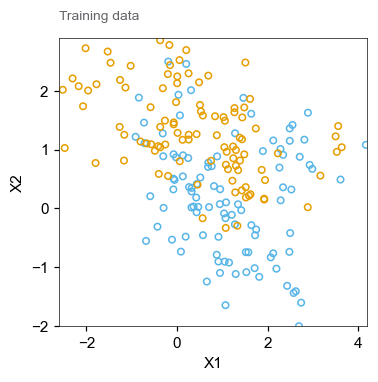

In [4]:
def plot_train_data(title, X_train, y_train):
    fig, ax = plt.subplots(figsize=(2.8, 2.8), dpi=110)
    ax.set_aspect(1.3)
    ax.scatter(X_train[:, 0], X_train[:, 1], s=18, facecolors='none',
               edgecolors=np.array([BLUE, ORANGE])[y_train])
    
    ax.set_xlim(-2.6, 4.2)
    ax.set_ylim(-2.0, 2.9)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax.text(-2.6, 3.2, title, color=GRAY4, fontsize=9)
    for spine in ax.spines.values():
        spine.set_color(GRAY1)
    return fig, ax

# test it
_, _ = plot_train_data('Training data', X_train, y_train)

# Linear classification

In [5]:
from sklearn.linear_model import LinearRegression
linear_regression_model = LinearRegression().fit(X_train, y_train)

def linear_predict(X):
    return 1*(linear_regression_model.predict(X) > 0.5)

In [6]:
# given a model prediction function computes X points on n x n grid and the
# corresponding predicted classes
def fill_prediction_grid(n1, n2, predict):
    x1, x2 = np.linspace(-2.6, 4.2, n1), np.linspace(-2.0, 2.9, n2)
    X = np.transpose([np.tile(x1, n2), np.repeat(x2, n1)])
    y = predict(X)
    return X, y


# given a model prediction function computes X0 and X1 n x n meshgrids
# and the corresponing predicted classes meshgrid
def fill_prediction_meshgrid(predict):
    n1, n2 = 1000, 1000
    X, y = fill_prediction_grid(n1, n2, predict)
    return X[:, 0].reshape(n1, n2), X[:, 1].reshape(n1, n2), y.reshape(n1, n2)


# given a model prediction function plots train data, model decision
# bounary and background dots
def plot_model(predict, title, X_train, y_train):
    fig, ax = plot_train_data(title, X_train, y_train)
    # plot background dots
    X, y = fill_prediction_grid(69, 99, predict)
    ax.scatter(X[:, 0], X[:, 1], marker='.', lw=0, s=2,
               c=np.array([BLUE, ORANGE])[y])
    # plot the decision boundary
    X0, X1, Y = fill_prediction_meshgrid(predict)
    ax.contour(X0, X1, Y, [0.5], colors=GRAY1, linewidths=[0.7])
    return fig, ax

(<Figure size 308x308 with 1 Axes>, <AxesSubplot:xlabel='X1', ylabel='X2'>)

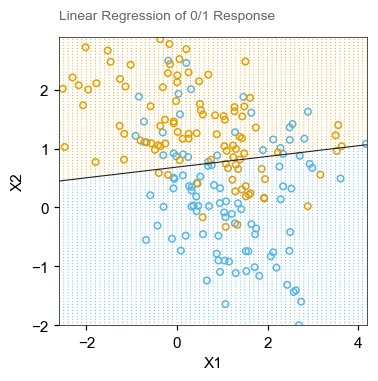

In [7]:
plot_model(linear_predict, 'Linear Regression of 0/1 Response', X_train, y_train)

# K-Nearest-Neighbor

In [12]:
from sklearn.neighbors import KNeighborsClassifier
neighbors15_classifier = KNeighborsClassifier(n_neighbors=5).fiµt(X_train, y_train)

AttributeError: 'KNeighborsClassifier' object has no attribute 'fiμt'

In [ ]:
plot_model(neighbors15_classifier.predict, '15-Nearest Neighbor Classifier', X_train, y_train)

In [10]:
neighbors1_classifier = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)

(<Figure size 308x308 with 1 Axes>, <AxesSubplot:xlabel='X1', ylabel='X2'>)

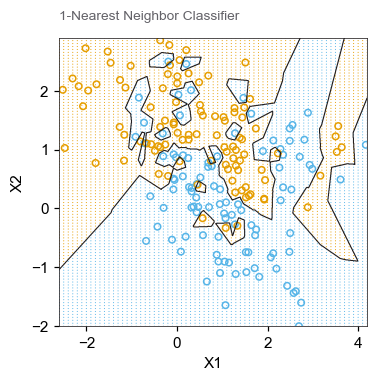

In [11]:
plot_model(neighbors1_classifier.predict, '1-Nearest Neighbor Classifier', X_train, y_train)

# Bayes Classifier

In [22]:
# set the known BLUE and ORANGE clusters means
blue_means = np.array([[-0.25343316, 1.7414788], [0.26669318, 0.3712341],
                       [2.09646921, 1.2333642], [-0.06127272, -0.2086791],
                       [2.70354085, 0.5968283], [2.37721198, -1.1864147],
                       [1.05690759, -0.6838939], [0.57888354, -0.0683458],
                       [0.62425213, 0.5987384], [1.67335495, -0.2893159]])
orange_means = np.array([[1.19936869, 0.2484086], [-0.30256110, 0.9454190],
                         [0.05727232, 2.4197271], [1.32932203, 0.8192260],
                         [-0.07938424, 1.6138017], [3.50792673, 1.0529863],
                         [1.61392290, 0.6717378], [1.00753570, 1.3683071],
                         [-0.45462141, 1.0860697], [-1.79801805, 1.9297806]])
all_means = np.vstack((blue_means, orange_means))

In [23]:
# even though we already know means and covariances, we need to
# do "fake fit", otherwise GaussianMixture model will not work
gaussian_mixture_model = GaussianMixture(
    n_components=20,
    covariance_type='spherical',
    means_init=all_means,
    random_state=1
).fit(all_means)
# set known covariances
gaussian_mixture_model.covariances_ = [1/5]*20
# it looks like a hack, but GaussianMixture uses precisions_cholesky_
# for predict_proba method. Because we changed covariances_ we need
# to recalculate precisions_cholesky_ too.
gaussian_mixture_model.precisions_cholesky_ = _compute_precision_cholesky(
    gaussian_mixture_model.covariances_,
    gaussian_mixture_model.covariance_type)

In [24]:
# sample 10,000 points for testing
X_test, y_test = gaussian_mixture_model.sample(10000)
# y_test contains sampled component indices
# index < 10 means that the class is BLUE (0)
y_test = 1*(y_test >= 10)

In [25]:


def optimal_bayes_predict(X):
    components_proba = gaussian_mixture_model.predict_proba(X)
    # first 10 components are BLUE(0), and others are BROWN(1)
    blue_proba = np.sum(components_proba[:, :10], axis=1)
    brown_proba = np.sum(components_proba[:, 10:], axis=1)
    y_hat = 1*(blue_proba < brown_proba)
    return y_hat



In [26]:
bayes_error_rate = 1 - accuracy_score(y_test, optimal_bayes_predict(X_test))
print(f'The optimal Bayes error rate = {bayes_error_rate}')

The optimal Bayes error rate = 0.2148


(<Figure size 308x308 with 1 Axes>, <AxesSubplot:xlabel='X1', ylabel='X2'>)

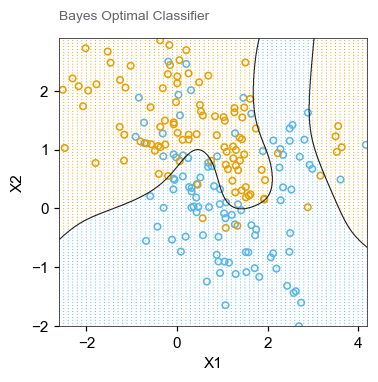

In [27]:
plot_model(optimal_bayes_predict, 'Bayes Optimal Classifier', X_train, y_train)